In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {c : i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i : c for c, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 8

def build_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        #print(w)
        for c in w + '.':
            X.append(context)
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]
            #print(f"{''.join([itos[i] for i in context])} ==> {c}")
    #print("X:", X, "=>", " y:", y)
    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y


random.seed(2023)
random.shuffle(words)
n_train = int(0.8*len(words))
n_eval = int(0.9*len(words))

X_train, y_train = build_dataset(words[:n_train])       # 80%
X_eval, y_eval = build_dataset(words[n_train:n_eval])   # 10%
X_test, y_test = build_dataset(words[n_eval:])          # 10%

torch.Size([182466, 8]) torch.Size([182466])
torch.Size([22839, 8]) torch.Size([22839])
torch.Size([22841, 8]) torch.Size([22841])


In [6]:
for x,y in zip(X_train[:20], y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> k
.......k --> o
......ko --> t
.....kot --> a
....kota --> r
...kotar --> o
..kotaro --> .
........ --> r
.......r --> o
......ro --> s
.....ros --> a
....rosa --> m
...rosam --> u
..rosamu --> n
.rosamun --> d
rosamund --> .
........ --> r
.......r --> o
......ro --> m
.....rom --> a


In [10]:
### Let's train a deeper neuro network
##  The classes we create here are the same API as nn.Module in pyTorch

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.b = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.b is None else [self.b])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalized to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    

class FaltternConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [11]:
torch.manual_seed(42); # seed rng for reproducibility

In [13]:
# orignial network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 100 # the number of neurons in the hidden layer of the MLP
# g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C = torch.randn((vocab_size, n_embd), generator = g) 
# layers = [
#     Linear(block_size * n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]


# with torch.no_grad():
#     # last layer: make less confident
#     layers[-1].gamma *= 0.1
#     #layers[-1].weight *= 0.1
#     # all other layers: apply gain
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             layer.weight *= 1.0 # 5/3

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
# print(sum(p.nelement() for p in parameters)) # number of parameters in total
# for p in parameters:
#     p.requires_grad = True

n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
    Embedding(vocab_size, n_embd),
    FaltternConsecutive(2), Linear(2 * n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FaltternConsecutive(2), Linear(2 * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FaltternConsecutive(2), Linear(2 * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # laste layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [16]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    # minbatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    Xb, yb = X_train[ix], y_train[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None  # zero gradients
    loss.backward()
    
    # update parameters
    lr = 0.1 if i < 100000 else 0.001 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     if i > 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization
    

      0/ 200000: 2.4244
  10000/ 200000: 2.3018
  20000/ 200000: 1.6919
  30000/ 200000: 2.1555
  40000/ 200000: 2.1346
  50000/ 200000: 2.2374
  60000/ 200000: 1.9038
  70000/ 200000: 1.8502
  80000/ 200000: 1.4968
  90000/ 200000: 1.9522
 100000/ 200000: 1.7684
 110000/ 200000: 1.4567
 120000/ 200000: 1.8486
 130000/ 200000: 1.9485
 140000/ 200000: 1.9959
 150000/ 200000: 2.1364
 160000/ 200000: 2.0031
 170000/ 200000: 2.1306
 180000/ 200000: 1.6612
 190000/ 200000: 1.9555


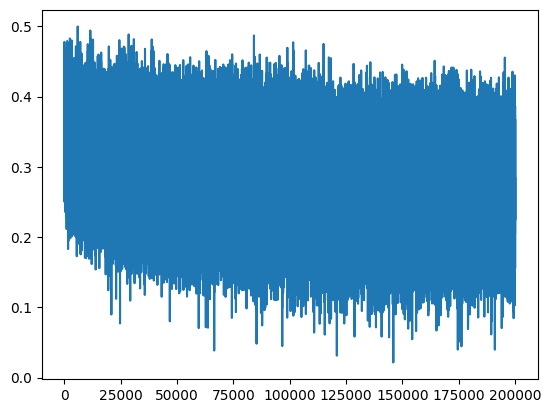

In [17]:
plt.plot(lossi)

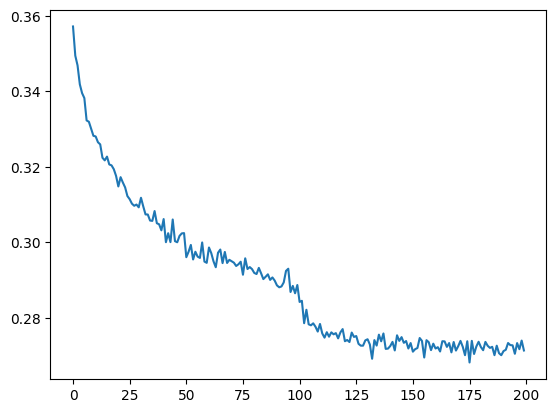

In [18]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

layer 4 (      Tanh): mean +0, std 0.59, saturated: 10.83%
layer 8 (      Tanh): mean -0, std 0.70, saturated: 19.03%
layer 12 (      Tanh): mean +0, std 0.69, saturated: 12.33%


Text(0.5, 1.0, 'activation distrubition')

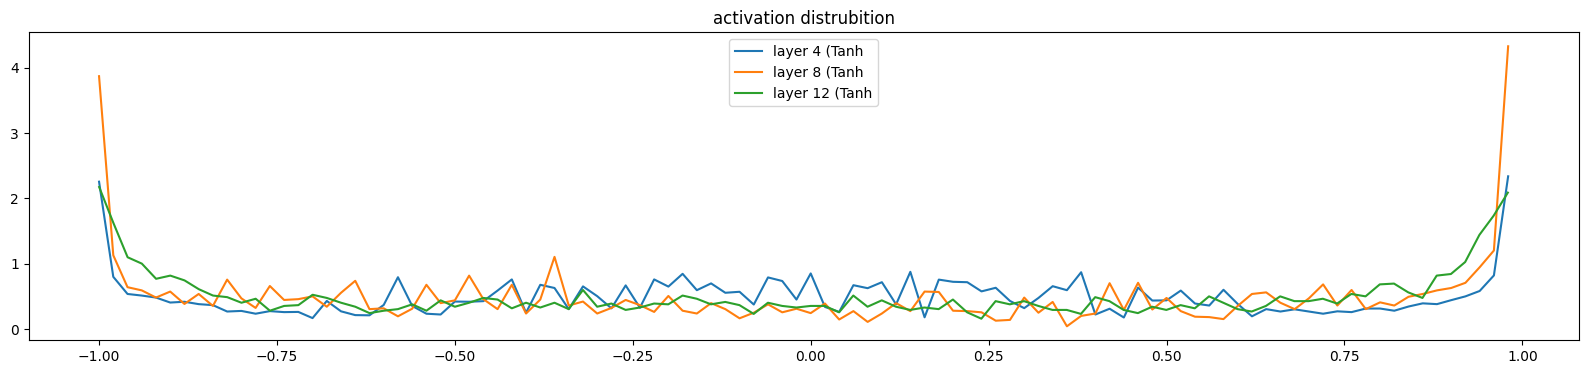

In [20]:
## visualize histograms
plt.figure(figsize = (20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+2.f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distrubition')


weight   (27, 24) | mean +0.000000 | std 9.266120e-03 | grad:data ratio 8.394603e-03
weight  (48, 128) | mean +0.000038 | std 6.160077e-03 | grad:data ratio 2.035367e-02
weight (256, 128) | mean +0.000011 | std 4.269114e-03 | grad:data ratio 2.523406e-02
weight (256, 128) | mean -0.000009 | std 4.406485e-03 | grad:data ratio 2.600195e-02
weight  (128, 27) | mean +0.000000 | std 1.985663e-02 | grad:data ratio 8.596674e-02


Text(0.5, 1.0, 'weights gradient distribution')

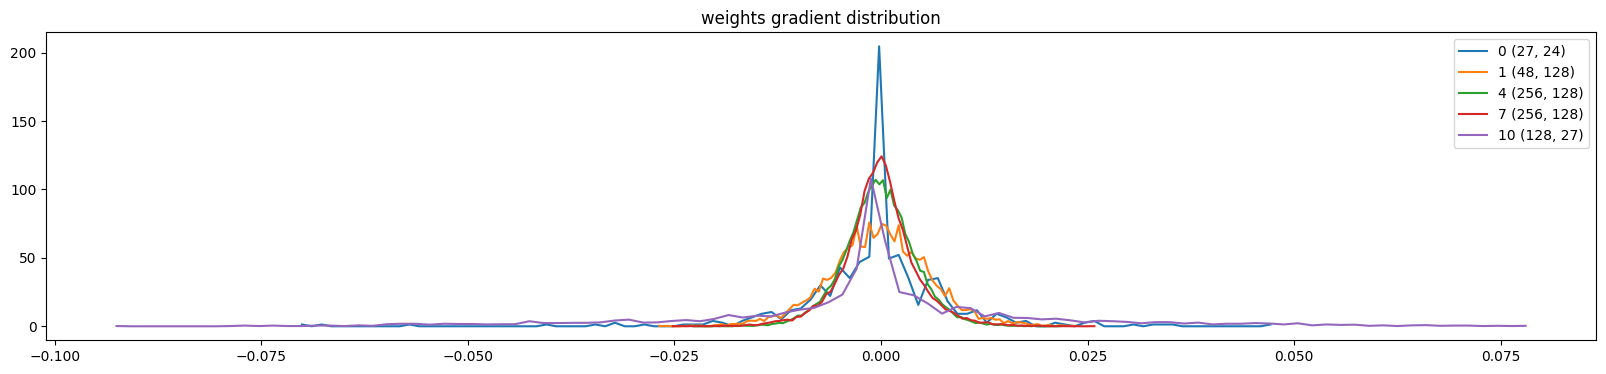

In [21]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if t.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [25]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (X_train, y_train),
    'eval': (X_eval, y_eval),
    'test': (X_test, y_test),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
    layer.training = False
split_loss('train')
split_loss('eval')
split_loss('test')

train 1.846051812171936
eval 1.9837863445281982
test 1.9814517498016357


In [26]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

geovae.
brianna.
karren.
conly.
abbashi.
ellarose.
ariya.
fariyah.
demareese.
kynzie.
peorne.
preelle.
finnley.
cambree.
ad.
glenlen.
zianiya.
preani.
besnieth.
trustyn.
